<a href="https://colab.research.google.com/github/smozwald/LandUseClassifier/blob/master/LandUseClassifier_Slovenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Use Classification using UNets

The purpose of this notebook is to test the effectiveness of Generative Adversarial Networks for land use and land cover classification (LULC), using a freely available dataset for slovenian landcover provided by EO-learn http://eo-learn.sentinel-hub.com/. There has been some research in this area which has shown promising results, however overall LULC typically relies on older, tested methods of machine learning to classify land cover based on spectral reflectance.
The method used by EO-learn in their example with this data got approximately 85% accuracy, utilizing a Temporal Fully-Convolutional Network, a time series based application of U-NET.

The data used in this study will be Sentinel-2 data, which includes 13 bands. THe dataset is pre-trained by the Slovenian government into different land cover classes. This data is reduced to 6 bands, corresponding to [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] .

Classes are
lulcid = 0, name = no data
lulcid = 1, name = cultivated land
lulcid = 2, name = forest
lulcid = 3, name = grassland
lulcid = 4, name = shrubland
lulcid = 5, name = water
lulcid = 6, name = wetlands
lulcid = 7, name = tundra
lulcid = 8, name = artificial surface
lulcid = 9, name = bareland
lulcid = 10, name = snow and ice

This is additionally an attempt to implement learnings from fast.ai, the fantastic web course for learning practical machine learning.￼


In [0]:

##Download packages, maybe won't use fastai
!curl -s https://course.fast.ai/setup/colab | bash
!pip install eo-learn

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.
    100% |████████████████████████████████| 931kB 21.3MB/s 
    100% |████████████████████████████████| 71kB 23.5MB/s 
    100% |████████████████████████████████| 24.6MB 1.9MB/s 
    100% |████████████████████████████████| 19.7MB 2.2MB/s 
    100% |████████████████████████████████| 22.4MB 2.0MB/s 
    100% |████████████████████████████████| 17.9MB 2.3MB/s 
    100% |████████████████████████████████| 10.8MB 4.6MB/s 
    100% |████████████████████████████████| 133kB 32.7MB/s 
    100% |████████████████████████████████| 51kB 21.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/91/4d/a4/7edb197fc9275482c0920a96eada1118751468cbb0ea31d250
  Stored in 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'landuseclassifier'

## Inspecting images

We will look at what we are getting with each band, as well as RGB, and also create a function to display the RGB values of these Sentinel-2 images

In [0]:
from eolearn.core import EOPatch
import os

data_dir = os.path.join(base_dir, 'data/eo_slovenia/')

sample = EOPatch.load(data_dir + 'eopatch-13x9')
print(sample)

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(69, 1010, 999, 6), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(69, 1010, 999, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(69, 1010, 999, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(69, 1010, 999, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(1010, 999, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(1010, 999, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: <ServiceType.WCS: 'wcs'>
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: (datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 12, 31, 0, 0))
  }
  bbox: BBox(((500162.82500207087, 5115595.613828535), (510157.6172221424, 5125693.036780571)), crs=EPSG:32633)
  timestamp: [datetime.datetime(2017, 1, 1, 10, 4, 7), ...

It looks like the array is actually 69 images stitched together, although it is unclear if they are adjacent images or different time period images. Also need to clarify which of the bands are included. Looks like values greater than 1 are eroneous, these are reset back to 1.

In [0]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

image = sample.data['BANDS'][0]

##Also need to normalize to from 0 to 1, rather than 0 to 2.8
np.putmask(image, image > 1.0, 1.0)

lulc = sample.mask_timeless['LULC'][:,:,0]

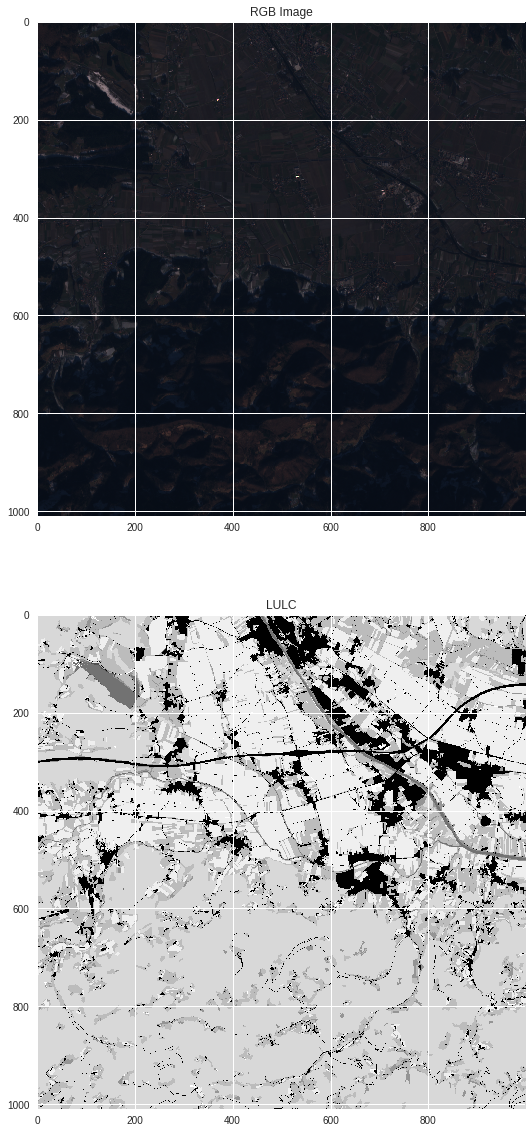

In [0]:
B = image[:,:,0]
G = image[:,:,1]
R = image[:,:,2]
rgb = np.dstack((R,G,B))

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (40,20))
ax1.set_title('RGB Image')
ax1.imshow(rgb)
ax2.set_title('LULC')
ax2.imshow(lulc)
plt.show()

## Making our dataset

We can see that the LULC basically aligns with the land cover map. Since we have 4 of these combinations, we will first reduce the dataset to only have 1 of the time series. We will set one aside for validation, and use the other 3 for training. We will train the model to classify 100*100 images in batches, which will hopefully get it running quicker. On inference, can also divide up images and classify.

In [0]:
images = []
for folder in os.listdir(data_dir):
  this_image = {}
  sample = EOPatch.load(data_dir + folder)
  bands = sample.data['BANDS'][0]
  np.putmask(bands, bands > 1.0, 1.0)
  lulc = sample.mask_timeless['LULC'][:,:,0]
  this_image['BANDS'] = bands
  this_image['LULC'] = lulc
  images.append(this_image)

In [0]:
np.unique(lulc)

array([0, 1, 2, 3, 4, 5, 6, 8, 9], dtype=uint8)

In [0]:
##Cut and divide these up into training and validation sets now. Will have last column just reflect oine prior
##For this we want 8 images of size 128, so will need the total to be 1024 * 1024.
original_image_size = (1010,999) #To transform back at end
for i, image in enumerate(images):
  bands = image['BANDS']
  new_img = np.zeros([1024,1024,6])
  new_img[:1010, :999, :] = bands
  lulc = image['LULC']
  new_lulc = np.zeros([1024,1024])
  new_lulc[:1010,:999] = lulc
  images[i]['BANDS'] = new_img
  images[i]['LULC'] = new_lulc
  

In [0]:
##Let's try get this working without PIL.

from tifffile import imsave

img_size = 128
train =os.path.join(data_dir, "data/")
target = os.path.join(data_dir, "target/")
if not os.path.exists(train):
    os.makedirs(train)
if not os.path.exists(target):
    os.makedirs(target)
    
total_im_factor = int(images[0]['BANDS'].shape[0]/img_size)

for i,image in enumerate(images):
  bands = image['BANDS']
  lulc = image['LULC'].astype(int)
  for x in range(total_im_factor):
    for y in range(total_im_factor):
      filename = 'img' + str(i) + '_x' + str(x) + '_y' + str(y) + '.tif'
      sub_bands = bands[x*img_size:x*img_size+img_size,y*img_size:y*img_size+img_size, :]
      sub_lulc = lulc[x*img_size:x*img_size+img_size,y*img_size:y*img_size+img_size]
      imsave(os.path.join(train, filename), sub_bands)
      imsave(os.path.join(target, filename), sub_lulc)
      

## Making our model

We now have our data in a pretty easy to use format. The data folder contains our images, whilst our target folder contains our targets, and it is possible to link these two.

Accuracy shall be assessed using standard map accuracy (overall accuracy, producer and user accuracy)


In [0]:
import glob
import random
random.seed(48)
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
import torchvision.transforms.functional as tf
import os

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'landuseclassifier'
model_dir = os.path.join(base_dir, "model/")
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

img_size = 128
bs = 8
data_dir = os.path.join(base_dir, 'data/eo_slovenia/')
train_dir = (os.path.join(data_dir, "data/"))
target_dir = (os.path.join(data_dir, "target/"))

folder_data = glob.glob(train_dir + "*.tif")
folder_target = glob.glob(target_dir + "*.tif")


Mounted at /content/gdrive


In [0]:

def get_y_fn(x): return os.path.join(target_dir, x.split("/")[-1])

random.shuffle(folder_data)
split = 0.8
train_images = folder_data[:int(len(folder_data)*0.8)]
train_classes = [get_y_fn(x) for x in train_images]
test_images = folder_data[int(len(folder_data)*0.8):]
test_classes = [get_y_fn(x) for x in test_images]


print(train_images[0])
print(get_y_fn(train_images[0]))


/content/gdrive/My Drive/landuseclassifier/data/eo_slovenia/data/img3_x0_y5.tif
/content/gdrive/My Drive/landuseclassifier/data/eo_slovenia/target/img3_x0_y5.tif


The hard part appears to be getting our images in as a tensor, since pytorch uses PIL. Need to import the images as arrays and the


In [0]:
from skimage.io import imread
from PIL import Image ##For the output mask
image = imread(folder_data[0])
transform = transforms.ToTensor()
t = transform(image)

class CustomDataset(Dataset):
  """This will process the images into beautiful tensors for learning.
  Need to work the classes a bit better methinks"""
  def __init__(self,images, target_dir, classes, class_ints = None, invalid_classes = None):
    """Images = List of images to add, in path format.
    target_dir = Target directory, where y images can also be appended.
    Classes are tied to integers in mask image, may require fine tuning for working classes and which are included as valid/invalid."""
    self.images = images
    self.target_dir = target_dir
    
    self.valid_classes = classes ##Need to make this also work with None
    if not self.valid_classes:
      pass
    self.class_ints = class_ints
    if not self.class_ints:
      self.class_ints = list(range(len(self.valid_classes)))
    self.invalid_class_ints = invalid_classes
    ##Remove invalid_classes from valid ones
      
    self.class_map = dict(zip(self.valid_classes,self.class_ints))
    
  def transform(self, image, targ):
    """Make some random flips and stuff."""
    """ if random.random() > 0.5:
      image = tf.hflip(image)
      targ = tf.hflip(targ)
    
    if random.random() > 0.5:
      image = tf.vflip(image)
      targ = tf.vflip(targ)"""
    
    image = tf.to_tensor(image)
    #image = tf.normalize(image, 0, 1) ##Normalize input
    targ = tf.to_tensor(targ).type(torch.long)
    return image, targ
  
  def get_y(self, image_file, target_dir):
    """Returns target image for image."""
    return os.path.join(target_dir, image_file.split("/")[-1])
    
  def encode_segmap(self, targ):
    """Segementing target array to classes.
    I think this is not actually needed since the images are encoded and i am a big dum dum.
    Maybe for other images which aren't encoded like this."""
    mask = np.zeros(targ.shape, dtype = int)
    for vclass in self.class_ints:
      mask[targ == vclass] = self.class_map[vclass]
    for iclass in self.invald_class_ints:
      mask[targ == iclass] = self.ignore_index
    return mask
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    img = imread(self.images[idx])
    targ = imread(self.get_y(self.images[idx], self.target_dir))
    #targ = self.encode_segmap(targ)
    targ = Image.fromarray(np.int8(targ))
    x, y = self.transform(img, targ)
    sample = {"x": x, "y":y}
    return x,y

In [0]:
from torch.utils.data import DataLoader
from matplotlib import colors

class_codes = ['no_data', 'cultivated_land', 'forest', 'grassland', 'shrubland', 'water',
               'wetland', 'tundra', 'artificial_surface', 'bareland','snow_and_ice']
void_classes = [0]
cmap = colors.ListedColormap(['k', '	#F0E68C', '#228B22', 'g', 'mediumseagreen', '#0000FF', 
                             '#008B8B', '#AFEEEE', '#808080', '#CD853F', 'FFFFFF'])

train_set = CustomDataset(train_images, target_dir, class_codes, void_classes)
valid_set = CustomDataset(test_images, target_dir,class_codes, void_classes)
train_loader = DataLoader(train_set, batch_size = bs, shuffle = True, num_workers = 1)
valid_loader = DataLoader(valid_set, batch_size = bs, shuffle = True, num_workers = 1)

In [0]:
x, y = train_set[1]
y.shape

torch.Size([1, 128, 128])

## Making a UNET

We will create a custom UNet class which implements the UNet architecture in its basic form. This should be extendable should we want to try and improve it later. A discussion of UNet can be found [here](https://medium.com/@keremturgutlu/semantic-segmentation-u-net-part-1-d8d6f6005066). Based on the implementation found at https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py.

![alt text](http://deeplearning.net/tutorial/_images/unet.jpg)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class UNetDownBlock(nn.Module):
  """As the UNet contracts, it does so with a bunch of these blocks effectively."""
  def __init__(self, in_size, out_size, padding, batch_norm):
    super(UNetDownBlock, self).__init__()
    block = []
    
    block.append(nn.Conv2d(in_size, out_size, kernel_size = 3,
                          padding = int(padding)))
    block.append(nn.ReLU())
    if batch_norm:
      block.append(nn.BatchNorm2d(out_size))
      
    block.append(nn.Conv2d(out_size, out_size, kernel_size = 3,
                          padding = int(padding)))
    block.append(nn.ReLU())
    if batch_norm:
      block.append(nn.BatchNorm2d(out_size))
      
    self.block = nn.Sequential(*block)
    
  def forward(self, x):
    out = self.block(x)
    return out

class UNetUpBlock(nn.Module):
  """As the UNet expands, it fills out to get back towards the original size."""
  def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
    super(UNetUpBlock, self).__init__()
    if up_mode == 'upconv':
      self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
    
    elif up_mode == 'upsample':
      self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))
    
    self.conv_block = UNetDownBlock(in_size, out_size, padding, batch_norm)
    
  def center_crop(self, layer, target_size):
    _, _, layer_height, layer_width = layer.size()
    diff_y = (layer_height - target_size[0]) // 2
    diff_x = (layer_width - target_size[1]) // 2
    return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

  def forward(self, x, bridge):
    up = self.up(x)
    crop1 = self.center_crop(bridge, up.shape[2:])
    out = torch.cat([up, crop1],1)
    out = self.conv_block(out)

    return out

class UNet(nn.Module):
  def __init__(self, in_channels=1, n_classes = 2, depth = 5, factor = 6, padding = True,
              batch_norm = False, up_mode = 'upconv'):
    """Implementation of UNet. Arguments as follows:
    in-channels: number of input channels, would be 1 for a single image, however in our case 6, should be read from tensor.
    n_classes (int). The output targets, in our initial example case is 10 for 10 land cover classes.
    depth: how deep the network should go.
    factor: The first layer filters is 2**factor, as is the same for every other layer.
    padding: To get output image of same dimensions (pretty handy for land cover classification,
    since you'll probably want to use it for GPS and such, although not necessary.)
    batch_norm: To use BatchNorm after activation functions."""
    
    super(UNet, self).__init__()
    assert up_mode in ('upconv','upsample')
    self.padding = padding
    self.depth = depth
    prev_channels = in_channels
    ##Create our list of modules for downwards
    self.down_path = nn.ModuleList()
    for i in range(depth):
      self.down_path.append(UNetDownBlock(prev_channels, 2**(factor+i),
                                         padding, batch_norm))
      prev_channels = 2**(factor+i)
      
    ##Create our upsampling modules, note that we will ned to reference our downsample models.
    self.up_path = nn.ModuleList()
    for i in reversed(range(depth-1)):
      self.up_path.append(UNetUpBlock(prev_channels, 2**(factor + i), up_mode,
                                     padding, batch_norm))
      prev_channels = 2** (factor+i)
    
    ##Get output classes
    self.last = nn.Conv2d(prev_channels, n_classes, kernel_size = 1)
    
  def forward(self, x):
    blocks = []

    for i, down in enumerate(self.down_path):
      x = down(x)
      if i != len(self.down_path) -1: ##So when it's not the final block, since that time we just upsample without another pool.
        blocks.append(x)
        x = F.max_pool2d(x, 2)

    for i, up in enumerate(self.up_path):
      x = up(x, blocks[-i-1]) ##Get the skip connection from before.

    return self.last(x)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels = 6, n_classes = 10, depth = 5, padding = True).to(device)
optim = torch.optim.Adam(model.parameters())
epochs = 500
criterion = nn.CrossEntropyLoss()
train_loss_hist = []
val_loss_hist = []
##If you want to load a checkpoint,specify
#checkpoint = torch.load(os.path.join(model_dir, "model_final.pt"))
#model.load_state_dict(checkpoint)

##Add here a accuracy metric
def accuracy_pixel(pred, y, void_code):
  """Accuracy in terms of correctly classified pixels"""
  pred = torch.argmax(pred, dim = 1)
  mask = y != void_code
  result = pred[mask] == y[mask]
  return result.float().mean().cpu().numpy()
  
def valid_metrics(v_loader, criterion, void_code, model, device, mode = 'training'):
  if mode == 'validation':
    accuracies = []
  for X,y in v_loader:
    X = X.to(device, dtype = torch.float)
    y = y.to(device)
    prediction = model(X)
    loss = criterion(prediction, y.squeeze(1))
    if mode == 'validation':
      accuracies.append(accuracy_pixel(prediction,y.squeeze(1), void_code))
    
  #acc = accuracy(y_array, predictions, void_classes)
  if mode =='training':
    return loss, 0
  else:
    return loss, np.mean(accuracies)

for epoch in range(epochs):
  preds = [] ##Testing prediction map
  for i, (X, y) in enumerate(train_loader):
    X = X.to(device, dtype = torch.float)
    y = y.to(device)
    prediction = model(X)
    preds.append(torch.argmax(prediction, dim = 1).cpu().numpy()) ##Testing prediction map
    ##Look to flatten/squeeze/whatever.
    loss = criterion(prediction, y.squeeze(1))
    
    optim.zero_grad()
    loss.backward()
    optim.step()
  val_loss,acc = valid_metrics(valid_loader, criterion, 0, model, device, 'validation')
  train_loss_hist.append(loss.item())
  val_loss_hist.append(val_loss.item())
  if epoch in [0,9,24]: ##To compare different model predictions.
    f_name = "model_step_" + str(epoch) + ".pt"
    torch.save(model.state_dict(), os.path.join(model_dir, f_name))
  
  print('Epoch {}, training loss: {}, validation loss: {}, valid accuracy %: {}'.format(epoch, loss.item(), val_loss.item(), acc*100))

f_name = "model_final.pt"
torch.save(model.state_dict(), os.path.join(model_dir, f_name))

Epoch 0, training loss: 1.8024941682815552, validation loss: 1.6570507287979126, valid accuracy %: 20.384640991687775
Epoch 1, training loss: 1.2273826599121094, validation loss: 1.3503085374832153, valid accuracy %: 54.10405993461609
Epoch 2, training loss: 1.3794022798538208, validation loss: 1.7342591285705566, valid accuracy %: 50.92316269874573
Epoch 3, training loss: 1.1057379245758057, validation loss: 0.8109765648841858, valid accuracy %: 65.26444554328918
Epoch 4, training loss: 0.9806514978408813, validation loss: 0.6515146493911743, valid accuracy %: 71.61889672279358
Epoch 5, training loss: 0.6928893327713013, validation loss: 0.8861635327339172, valid accuracy %: 72.64341115951538
Epoch 6, training loss: 1.0075109004974365, validation loss: 1.0902459621429443, valid accuracy %: 68.670654296875
Epoch 7, training loss: 1.0963060855865479, validation loss: 0.5793613195419312, valid accuracy %: 73.33087921142578
Epoch 8, training loss: 0.5440753102302551, validation loss: 0.53

## Visualizing Classifications

To end, we will visualize how the classification maps compare to the ground truth data at different stages of the model.

This isn't as easy as I first thought it would be. There is lots of kings in pytorch prediction and visualization I have to work out.

In [0]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
m = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i, mod in enumerate(['step_0','step_4','step_24', 'final']):
  m.append(UNet(in_channels = 6, n_classes = 10, depth = 5, padding = True))
  checkpoint = torch.load(os.path.join(model_dir, "model_" + mod +".pt"))
  m[i].load_state_dict(checkpoint)
  m[i].eval()
  m[i] = m[i]
                          
                          
                       
##Get one to check, make sure the code works.
test = valid_set[0] ##To classify
arr = test[0].unsqueeze(0)
img = test[0].numpy()[0:3] ##Only visual layers
img *= 255.0/img.max()
img = np.transpose(img, (1,2,0))
pil_image = Image.fromarray(img.astype('uint8'))
classes = test[1].numpy().astype(int).squeeze(0)
                          

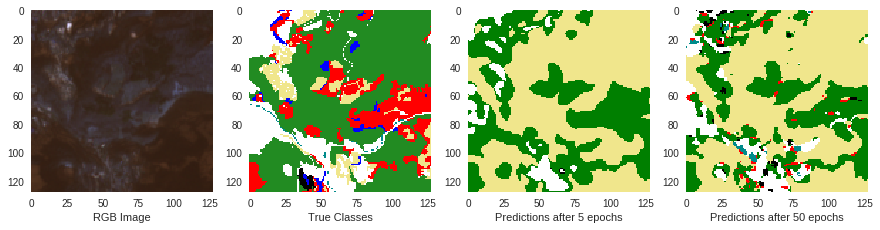

In [0]:
from matplotlib.pyplot import imshow
plt.rcParams["axes.grid"] = False

class_codes = ['no_data', 'cultivated_land', 'forest', 'grassland', 'shrubland', 'water',
               'wetland', 'tundra', 'artificial_surface', 'bareland','snow_and_ice']
void_classes = [0]
color_map = colors.ListedColormap(['k', '#F0E68C', '#228B22', 'g', 'r', '#0000FF', 
                             '#008B8B', '#AFEEEE', '#808080', '#CD853F', '#FFFFFF'])

def predict_single_image(model, data):
  """Should contain a tensor and correct output as input, will return prediction and ground truth numpy arrays.
  Input will be converted to a dataloader and then model applied for prediction."""
  loader = DataLoader([data])
  for X,y in loader:
    X = X.to('cpu', dtype = torch.float)
    pred = model.to('cpu')(X)
    max_pred = torch.argmax(pred, dim =1).cpu().numpy().squeeze(0)
    y = y.cpu().numpy().squeeze(0)
  return max_pred, y.squeeze(0)

low_pred, y = predict_single_image(m[2], valid_set[0])
high_pred, y = predict_single_image(m[3], valid_set[0])

def compare_figs(img, truth, pred1, pred2):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,20))
  ax1.imshow(img)
  ax1.set_xlabel('RGB Image')
  ax2.imshow(truth, cmap = color_map)
  ax2.set_xlabel("True Classes")
  ax3.imshow(pred1, cmap = color_map)
  ax3.set_xlabel("Predictions after 5 epochs")
  ax4.imshow(pred2, cmap = color_map)
  ax4.set_xlabel("Predictions after 50 epochs")
  plt.show()
                                           

compare_figs(pil_image, y, low_pred, high_pred)

So after 500 epoches, it's not classifying that well. The broader shapes are appearing well, but others are not.

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *